In [1]:
import numpy as np
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import MobileNetV2

import itertools
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
import os

In [2]:
train_path = 'fruits-360/Training'
test_path = 'fruits-360/Test'
classes = ['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mango Red', 'Mangostan', 'Maracuja', 'Melon Piel de Sapo', 'Mulberry', 'Nectarine', 'Nectarine Flat', 'Nut Forest', 'Nut Pecan', 'Onion Red', 'Onion Red Peeled', 'Onion White', 'Orange', 'Papaya', 'Passion Fruit', 'Peach', 'Peach 2', 'Peach Flat', 'Pear', 'Pear 2', 'Pear Abate', 'Pear Forelle', 'Pear Kaiser', 'Pear Monster', 'Pear Red', 'Pear Stone', 'Pear Williams', 'Pepino', 'Pepper Green', 'Pepper Orange', 'Pepper Red', 'Pepper Yellow', 'Physalis', 'Physalis with Husk', 'Pineapple', 'Pineapple Mini', 'Pitahaya Red', 'Plum', 'Plum 2', 'Plum 3', 'Pomegranate', 'Pomelo Sweetie', 'Potato Red', 'Potato Red Washed', 'Potato Sweet', 'Potato White', 'Quince', 'Rambutan', 'Raspberry', 'Redcurrant', 'Salak', 'Strawberry', 'Strawberry Wedge', 'Tamarillo', 'Tangelo', 'Tomato 1', 'Tomato 2', 'Tomato 3', 'Tomato 4', 'Tomato Cherry Red', 'Tomato Heart', 'Tomato Maroon', 'Tomato not Ripened', 'Tomato Yellow', 'Walnut', 'Watermelon']

In [3]:
#Data augmentation and validation split
train_datagen = ImageDataGenerator(shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

batch_size=50

train_batches = train_datagen.flow_from_directory(train_path, target_size=(100,100), classes=classes, batch_size=batch_size, subset='training')
validation_batches = train_datagen.flow_from_directory(train_path, target_size=(100,100), classes=classes, batch_size=batch_size, subset='validation')
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(100,100), classes=classes, batch_size=batch_size)

Found 54190 images belonging to 131 classes.
Found 13502 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


# Build and train CNN

In [4]:
dropout_rate = 0.5

#load pre-trained model (without output layer)
base_model = MobileNetV2(
    input_shape=(100,100,3),
    include_top=False,
    weights='imagenet',
    pooling="max",
)#default alpha, weights, classes, classifier_activation

x = base_model.output
x = Dense(2048, activation='relu')(x)
x = Dropout(dropout_rate)(x)
predictions = Dense(len(classes), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in model.layers:
    layer.trainable = True

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 101, 101, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 50, 50, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 50, 50, 32)   128         Conv1[0][0]                      
______________________________________________________________________________________________

In [5]:
learning_rate=.001
loss_function='categorical_crossentropy'
model.compile(Adam(lr=learning_rate), loss=loss_function, metrics=['accuracy'])

In [6]:
# datetime object containing current date and time
now = datetime.now()
# dd/mm/YY H:M:S
dt_string = now.strftime("%d-%m-%Y_%H-%M-%S")
iter_count=0

In [7]:
if not os.path.exists("models/pre-trained/"):
    os.mkdir("models/pre-trained")
if not os.path.exists("models/pre-trained/"+dt_string):
    os.mkdir("models/pre-trained/"+dt_string)
    
summary_file = open("models/pre-trained/"+dt_string+"/summary.txt", "w")

def printModelSummaryToFile(line):
    summary_file.write(line+"\n")

In [8]:
model.summary(print_fn=printModelSummaryToFile)
summary_file.write("\nLearning Rate: "+str(learning_rate)+"\n")
summary_file.write("Loss Function: "+str(loss_function)+"\n")
summary_file.write("Dropout Rate: "+str(dropout_rate)+"\n")
summary_file.write("Batch Size: "+str(batch_size)+"\n")
summary_file.close()

#Callbacks
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=25)
mc = ModelCheckpoint("models/pre-trained/"+dt_string+"/"+dt_string+"_best.h5", monitor='val_accuracy', mode='max', save_best_only=True)

start_time = datetime.now()

history = model.fit(x=train_batches, validation_data=validation_batches, epochs=999, verbose=2, callbacks=[es, mc])

end_time = datetime.now()
time_delta =(end_time-start_time).total_seconds()

summary_file = open("models/pre-trained/"+dt_string+"/summary.txt", "a")
summary_file.write("Time Train Start: "+str(start_time)+"\n")
summary_file.write("Time Train End: "+str(end_time)+"\n")
summary_file.write("Time Delta: "+str(time_delta)+"\n")
summary_file.close()

model.save("models/pre-trained/"+dt_string+"/"+dt_string+"_last.h5")

Epoch 1/999
1084/1084 - 156s - loss: 0.6212 - accuracy: 0.8532 - val_loss: 9.1231 - val_accuracy: 0.0612
Epoch 2/999
1084/1084 - 161s - loss: 0.2151 - accuracy: 0.9486 - val_loss: 3.7351 - val_accuracy: 0.2763
Epoch 3/999
1084/1084 - 161s - loss: 0.1481 - accuracy: 0.9662 - val_loss: 5.8767 - val_accuracy: 0.2305
Epoch 4/999
1084/1084 - 160s - loss: 0.1513 - accuracy: 0.9668 - val_loss: 7.5606 - val_accuracy: 0.2335
Epoch 5/999
1084/1084 - 161s - loss: 0.1210 - accuracy: 0.9735 - val_loss: 4.9924 - val_accuracy: 0.2720
Epoch 6/999
1084/1084 - 166s - loss: 0.1250 - accuracy: 0.9728 - val_loss: 4.4518 - val_accuracy: 0.3103
Epoch 7/999
1084/1084 - 161s - loss: 0.1025 - accuracy: 0.9778 - val_loss: 8.7301 - val_accuracy: 0.2387
Epoch 8/999
1084/1084 - 161s - loss: 0.0843 - accuracy: 0.9822 - val_loss: 4.8549 - val_accuracy: 0.4174
Epoch 9/999
1084/1084 - 161s - loss: 0.0926 - accuracy: 0.9807 - val_loss: 2.3873 - val_accuracy: 0.6319
Epoch 10/999
1084/1084 - 161s - loss: 0.0908 - accuracy

# Prediction

In [9]:
best_model = load_model("models/pre-trained/"+dt_string+"/"+dt_string+"_best.h5")

In [10]:
test_imgs, test_labels = next(test_batches)

In [11]:
test_labels = np.argmax(test_labels, axis=-1)
test_labels

array([ 49,  84, 122,  84,  34,  48,  12,  63,   7, 127,   7,  50,  22,
        21, 108,  80,  95,  85,  27, 108,  85,  56, 126,   4,  25, 103,
       105,  97,  90,  81, 109,  52,  79, 107, 104,  24,  94,  41,  58,
        45,  57,  59,  56, 122, 129,  31, 112,  89,  34,   0], dtype=int64)

In [12]:
predictions = np.argmax(best_model.predict(x=test_imgs, steps=1, verbose=0), axis=-1)

In [13]:
predictions

array([ 49,  84, 122,  84,  34,  48,  12,  63,   0, 127,  70,  50,  22,
        21,  74,  80,  95,  85,  27, 107,  85,  56, 126,   4,  25, 103,
       105,  97,  90,  81, 109,  52,  79, 107, 104,  24,  94,  41,  58,
        45,  57,  59,  56, 122, 129,  31, 112,  89,  34,   0], dtype=int64)

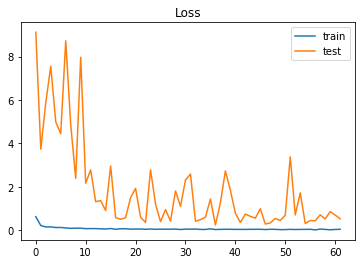

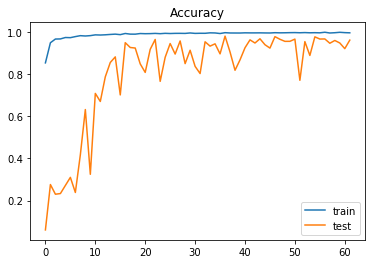

In [14]:
# plot training history
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.savefig("models/pre-trained/"+dt_string+"/loss_history.png", bbox_inches='tight')
plt.show()

plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.savefig("models/pre-trained/"+dt_string+"/accuracy_history.png", bbox_inches='tight')
plt.show()

In [15]:
# evaluate the model
_, train_acc = best_model.evaluate(train_batches, verbose=1)
_, test_acc = best_model.evaluate(test_batches, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
summary_file = open("models/pre-trained/"+dt_string+"/summary.txt", "a")
summary_file.write("Train Accuracy: "+str(train_acc)+"\n")
summary_file.write("Test Accuracy: "+str(test_acc)+"\n")
summary_file.close()

454/454 [==============================] - 13s 28ms/step - loss: 0.3612 - accuracy: 0.9628
Train: 0.996, Test: 0.963


In [16]:
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 101, 101, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 50, 50, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 50, 50, 32)   128         Conv1[0][0]                      
______________________________________________________________________________________________